### Extended Analysis: ADHD and Bipolar Disorder Identification  - by yatbear

This notebook contains several analyses I conducted before for the depression prediction (e.g. PCA, K-S test, five classification methods), which are reapplied on the ADHD and Bipolar Identification problem. New analyses (primarily in the prediction section) are also added.

In [1]:
import pandas as pd
import numpy as np

df_patient = pd.read_csv('patient_info.csv')
df_disorders = pd.read_csv('disorders.csv')
df_questionnaire = pd.read_csv('questionnaire.csv')
df_base_concen = pd.read_csv('base_concen.csv')

### Descriptive Analysis

#### Q1. How many mutually exclusive ADHD and Bipolar samples do we have?

In [2]:
c1, c2 = 0, 0
adhd_id, bipolar_id = list(), list()

for i, a, b in df_disorders[['Patient_ID', 'ADHD', 'Bipolar']].values:
    if a == 1 and b == 0:
        c1 += 1
        adhd_id.append(i)
    elif a == 0 and b == 1:
        c2 += 1
        bipolar_id.append(i)
        
print 'Number of ADHD patients (without Bipolar) is', c1
print 'Number of Bipolar patients (without ADHD) is', c2

Number of ADHD patients (without Bipolar) is 1040
Number of Bipolar patients (without ADHD) is 307


In [3]:
# Extract Learning Disablity Screening Questionnair data
df_questionnaire.drop(['Patient_ID', 'LDS_Respondent'], axis=1, inplace=True)
lds = list()
for col in df_questionnaire.columns:
    if 'LDS' in col:
        lds.append(col)
df_lds = df_questionnaire[lds]

In [4]:
# Separate baseline from concentration rCBF values
df_base_concen.drop(['Baseline_header_id', 'Concentration_header_id'], axis=1, inplace=True)
base, concen = list(), list()
for col in df_base_concen.columns:
    if 'Baseline' in col:
        base.append(col)
    elif 'Concentration' in col:
        concen.append(col)
df_base = df_base_concen[base]
df_concen = df_base_concen[concen]

In [5]:
# Get basic personal info and rCBF values
df_patient = df_patient[['Patient_ID', 'Age', 'Gender_id', 'race_id', 'location_id']]
df = pd.concat([df_patient, df_lds, df_base, df_concen], axis=1)

In [6]:
# Original positive and negative features
df_adhd = df.loc[df['Patient_ID'].isin(adhd_id)].drop(['Patient_ID'], axis=1)
df_bipolar = df.loc[df['Patient_ID'].isin(bipolar_id)].drop(['Patient_ID'], axis=1)
df_adhd.shape, df_bipolar.shape

((1040, 457), (307, 457))

### Exploratory Analysis

#### Principal Component Analysis

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Plot explained variance ratio
def plot(ex_var_ratio):
    plt.plot(ex_var_ratio)
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Number of Principal Components')

def pca(X, n):
    pca = PCA(n_components=n)
    pca_X = pca.fit_transform(X)
    
    print '\nExplained Variance Ratios:'
    print pca.explained_variance_ratio_
    print '\nSum of Explained Variance Ratios:', 
    print np.sum(pca.explained_variance_ratio_)

    return pca_X, pca.explained_variance_ratio_

In [8]:
from sklearn.decomposition import SparsePCA

# Compute explained variance ratio of transformed data
def compute_explained_variance_ratio(transformed_data):
    explained_variance = np.var(transformed_data, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    explained_variance_ratio = np.sort(explained_variance_ratio)[::-1]
    return explained_variance_ratio

def sparse_pca(X, n):
    spca = SparsePCA(n_components=n) 
    spca_transform = spca.fit_transform(X)
    ex_var_ratio = compute_explained_variance_ratio(spca_transform)
    return spca_transform, ex_var_ratio

####  Q2. How many dimensions can capture more than 95% variance of the LDS data (using PCA)?
- Sixty.


Explained Variance Ratios:
[ 0.25319082  0.06375808  0.05584385  0.04520017  0.0364009   0.03038621
  0.02536708  0.02317602  0.02144985  0.01871833  0.01728378  0.01623972
  0.0158757   0.01371272  0.01336975  0.0127428   0.01239438  0.01094738
  0.01017911  0.00986827  0.00941541  0.00924407  0.00904353  0.00849211
  0.00822588  0.00804994  0.00774795  0.00745031  0.00736814  0.00722003
  0.00709658  0.00678852  0.00666003  0.00633405  0.00626434  0.0062329
  0.00601061  0.00589109  0.00575607  0.00569043  0.00555617  0.00544859
  0.00541802  0.00534806  0.00520097  0.00512579  0.0050675   0.00493996
  0.00486919  0.00479003  0.00472562  0.00459259  0.0044639   0.00445442
  0.00442158  0.00417666  0.00412479  0.00408071  0.00394264  0.0038429 ]

Sum of Explained Variance Ratios: 0.945676990608


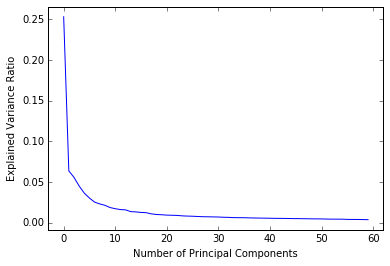

In [9]:
pca_lds, ex_var_ratio = pca(df_lds.get_values(), 60)
plot(ex_var_ratio)

#### Therefore, use Sparse PCA to reduce the dimension of the LDS questionnaire instead, keep 10 dimensions only.

/Library/Python/2.7/site-packages/sklearn/linear_model/least_angle.py:162: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':


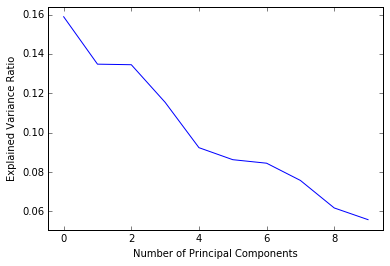

In [10]:
spca_lds, ex_var_ratio = sparse_pca(df_lds.get_values(), 10)
plot(ex_var_ratio)

#### Q3. How many dimensions can capture more than 99% variance of the baseline rCBF values (using PCA)?
- One. The first principal component captures 99.73% variance. But here three dimensions are kept for further analysis.


Explained Variance Ratios:
[  9.97327057e-01   1.93945335e-03   2.41780411e-04]

Sum of Explained Variance Ratios: 0.99950829102


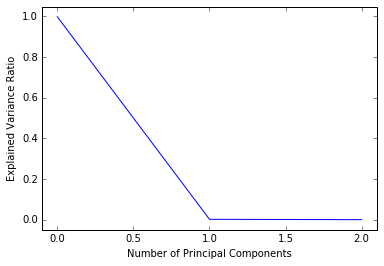

In [11]:
pca_base, ex_var_ratio = pca(df_base.get_values(), 3)
plot(ex_var_ratio)

#### Q4. How many dimensions can capture more than 99% variance of the concentration rCBF values (using PCA)?
- One. The first principal component captures 99.79% variance. But here three dimensions are kept for further analysis.


Explained Variance Ratios:
[  9.97899257e-01   1.49942535e-03   1.96982752e-04]

Sum of Explained Variance Ratios: 0.999595665312


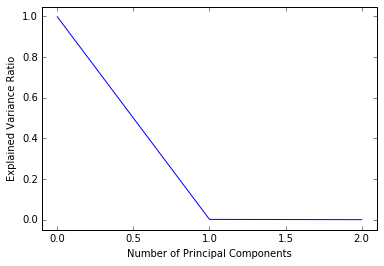

In [12]:
pca_concen, ex_var_ratio = pca(df_concen.get_values(), 3)
plot(ex_var_ratio)

In [13]:
# Put everything together
df_lds = pd.DataFrame(spca_lds)
df_base = pd.DataFrame(pca_base)
df_concen = pd.DataFrame(pca_concen)
df_reduced = pd.concat([df_patient, df_lds, df_base, df_concen], axis=1)

In [14]:
# Reduced ADHD and Bipolar features
df_adhd = df_reduced.loc[df_reduced['Patient_ID'].isin(adhd_id)].drop(['Patient_ID'], axis=1)
df_bipolar = df_reduced.loc[df_reduced['Patient_ID'].isin(bipolar_id)].drop(['Patient_ID'], axis=1)

print 'Reduced ADHD sample size:', df_adhd.shape
print 'Reduced Bipolar sample size:', df_bipolar.shape

Reduced ADHD sample size: (1040, 20)
Reduced Bipolar sample size: (307, 20)


#### Thus, number of features are reduced from 457 to 20.

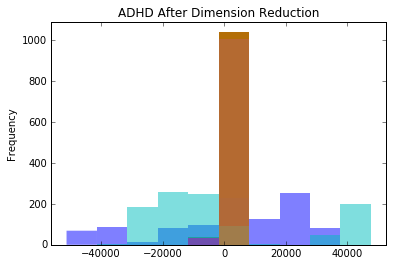

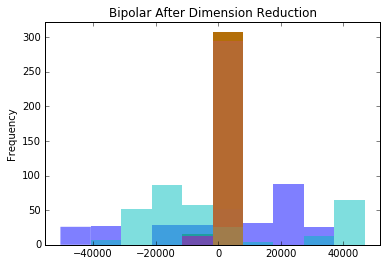

In [15]:
# Have a look at the distribution of reduced data
df_adhd.plot(kind='hist', alpha=0.5, legend=None, title='ADHD After Dimension Reduction')
df_bipolar.plot(kind='hist', alpha=0.5, legend=None, title='Bipolar After Dimension Reduction')

### Inferential Analysis

In [16]:
adhd = df_adhd.get_values().T
bipolar = df_bipolar.get_values().T

#### Q5. Are the reduced features from the ADHD and Bipolar samples drawn from the same continuous distribution?

#### Kolmogorov-Smirnov Goodness-of-Fit Test

Use K-S test to test if 2 independent samples (ADHD and Bipolar) are drawn from the same continuous distribution. All 20 features (resulted from the dimensionality reduction) are tested.

In [17]:
from scipy.stats import pearsonr
from scipy.stats import chisquare
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from skbio.stats.power import subsample_power

pearsonr_test = lambda x: pearsonr(x[0], x[1])[1]
chi_test = lambda x: chisquare(x[0], x[1])[1]
ks_test = lambda x: ks_2samp(x[0], x[1])[1]
anderson_ksamp_test = lambda x: anderson_ksamp(x)[2]

# Computer power of a sub sample set
def compute_sub_power(test, samples):
    pwr, counts = subsample_power(test=test,
                                   samples=samples,
                                   max_counts=300,
                                   min_counts=30,
                                   counts_interval=10,
                                   draw_mode="ind",
                                   alpha_pwr=0.05)
    return pwr, counts

#### Compute p-values on the reduced data

In [18]:
p_vals = list()
for a, b in zip(adhd, bipolar):
    p_vals.append(round(ks_2samp(a, b)[1], 5))
print p_vals

[0.91579, 1e-05, 0.57799, 0.02654, 0.93906, 6e-05, 0.17441, 0.0468, 0.02826, 0.04088, 0.19297, 0.50919, 0.00082, 0.00713, 0.233, 0.06367, 0.0, 0.21373, 0.64792, 1e-05]


#### Sample from the reduced data and plot power curves

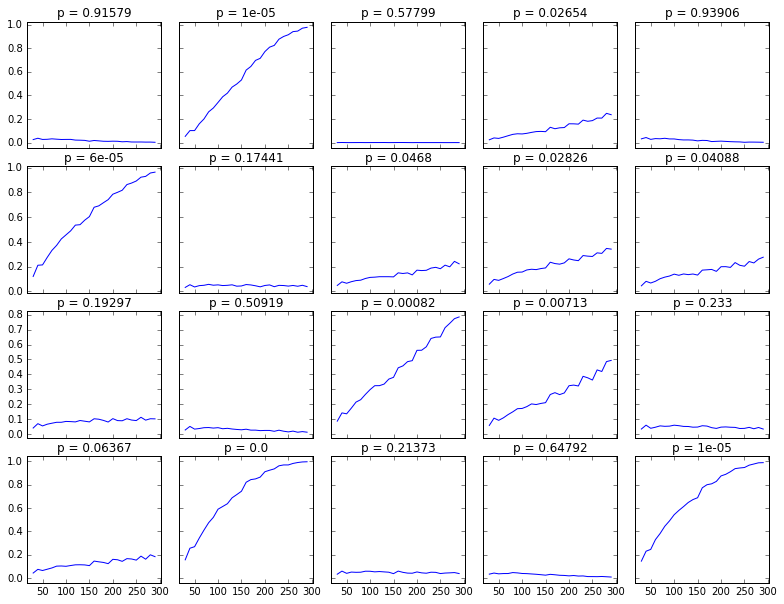

In [19]:
from mpl_toolkits.axes_grid1 import Grid

plt.close('all')
fig = plt.figure()
fig.set_size_inches(11, 8.5)

grid = Grid(fig, rect=111, nrows_ncols=(4, 5),
            axes_pad=0.25, label_mode='L',
            )
    
def plot_power(i, ax):
    a, b = adhd[i], bipolar[i]
    samples = [np.array(a), np.array(b)]
    pwr, counts = compute_sub_power(ks_test, samples) 
    ax.plot(counts, pwr.mean(0))
    
for i, ax in enumerate(grid):
    if i < 20:
        plot_power(i, ax)
        title = 'p = ' + str(p_vals[i])
        ax.set_title(title)

plt.tight_layout()

As we can see from the plotted power curves above, ten features (with large p-values) obviously follow the null distribution. For those whose p-values are slightly smaller than the alpha power(0.05), it is hard to be tell whether the corresponding powers will eventually approximate 1.0 due to the lack of data, but we can still see the trend of increasing.

### Predictive Analysis

Predict ADHD disorder against Bipolar disorder using 10-fold Cross Validation. 

Since we have 1040 ADHD samples out of 1347 samples, the chance is 77.2%, we want the prediction accuracy much larger than the chance.

#### Q6 - Q14. What are the performances of different classification methods on the current features?

- Logistic Regression Classifier
- K Nearest Neighbors Classifier
- Support Vector Machine (linear kernel)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- Random Forest Classifier
- Gradient Boosting Classifier
- Extra Trees Classifier
- AdaBoost Classifier

In [20]:
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.cross_validation import KFold

# Train the given classifier
def train_clf(clf, train_feats, train_labels):
    # Supervised training
    clf.fit(train_feats, train_labels)
    
# Test the given classifier and calculate accuracy
def test_clf(clf, test_feats, test_labels):
    # Predict using test set
    predicted = clf.predict(test_feats)
    # Compute accuracy
    acc = np.mean(predicted == test_labels)
    return predicted, acc

# Compute accuracy of a model trained with a specific number(n) of samples 
def compute_acc(clf, n):
    train_clf(clf, train_X[:n], train_y[:n])
    predict_y, acc = test_clf(clf, test_X, test_y)
    return acc

# Leave one out cross validation
def loo_cv(clf, X, y):
    loo = LeaveOneOut(len(X))
    scores = cross_validation.cross_val_score(clf, X, y, cv=loo)
    return scores.mean(), scores.std()

# K-fold cross validation
def kf_cv(clf, X, y, k=10):
    kf = KFold(len(X), n_folds=k)
    scores = cross_validation.cross_val_score(clf, X, y, cv=kf)
    return scores.mean(), scores.std()

In [21]:
df_all = pd.concat([df_adhd, df_bipolar], axis=0)
X = df_all.values
y = [0] * df_adhd.shape[0] + [1] * df_bipolar.shape[0]

print 'Double check data size:', X.shape, len(y)

Double check data size: (1347, 20) 1347


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

# Logistic Regression
lg = LogisticRegression(penalty='l2')
acc_lg, acc_std_lg = kf_cv(lg, X, y)

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=7)
acc_knn, acc_std_knn = kf_cv(knn, X, y)

# Support Vector Machine - Linear Kernel
svc = LinearSVC()
acc_svm, acc_std_svm = kf_cv(svc, X, y)

# Linear Discriminant Analysis
lda = LDA()
acc_lda, acc_std_lda = kf_cv(lda, X, y)

# Quadratic Discriminant Analysis
qda = QDA()
acc_qda, acc_std_qda = kf_cv(qda, X, y)

# Random Forest
rf = RandomForestClassifier(n_estimators=30) 
acc_rf, acc_std_rf = kf_cv(rf, X, y) 

# Gradient Boosting 
gb = GradientBoostingClassifier(n_estimators=20, max_depth=3)
acc_gb, acc_std_gb = kf_cv(gb, X, y)

# Extra Trees  
et = ExtraTreesClassifier(n_estimators=40, max_depth=5)
acc_et, acc_std_et = kf_cv(et, X, y)

# AdaBoost
ada = AdaBoostClassifier()
acc_ada, acc_std_ada = kf_cv(ada, X, y)

In [23]:
print 'Logistic Regression accuracy is %0.4f (+/- %0.3f)' % (acc_lg, acc_std_lg)
print 'K Nearest Neighbors accuracy is %0.4f (+/- %0.3f)' % (acc_knn, acc_std_knn)
print 'Support Vector Machine (Linear Kernel) accuracy is %0.4f (+/- %0.3f)' % (acc_svm, acc_std_svm)
print 'Linear Discriminant Analysis accuracy is %0.4f (+/- %0.3f)' % (acc_lda, acc_std_lda)
print 'Quadratic Discriminant Analysis accuracy is %0.4f (+/- %0.3f)' % (acc_qda, acc_std_qda)
print 'Random Forest accuracy is %0.4f (+/- %0.3f)' % (acc_rf, acc_std_rf)
print 'Gradient Boosting accuracy is %0.4f (+/- %0.3f)' % (acc_gb, acc_std_gb)
print 'Extra Trees accuracy is %0.4f (+/- %0.3f)' % (acc_et, acc_std_et)
print 'AdaBoost accuracy is %0.4f (+/- %0.3f)' % (acc_ada, acc_std_ada)

Logistic Regression accuracy is 0.7664 (+/- 0.393)
K Nearest Neighbors accuracy is 0.7191 (+/- 0.352)
Support Vector Machine (Linear Kernel) accuracy is 0.6534 (+/- 0.217)
Linear Discriminant Analysis accuracy is 0.7524 (+/- 0.378)
Quadratic Discriminant Analysis accuracy is 0.7126 (+/- 0.302)
Random Forest accuracy is 0.7502 (+/- 0.379)
Gradient Boosting accuracy is 0.7657 (+/- 0.382)
Extra Trees accuracy is 0.7709 (+/- 0.395)
AdaBoost accuracy is 0.7214 (+/- 0.323)


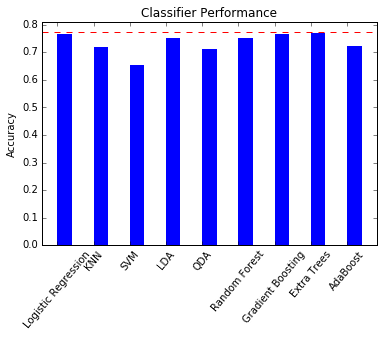

In [24]:
from __future__ import division

# Visualize classifier performance
acc = [acc_lg, acc_knn, acc_svm, acc_lda, acc_qda, acc_rf, acc_gb, acc_et, acc_ada]
clf_names = ['Logistic Regression', 'KNN', 'SVM', 'LDA', 'QDA', \
             'Random Forest', 'Gradient Boosting', 'Extra Trees', 'AdaBoost']
x = range(len(acc))

width = 0.6/1.5
plt.bar(x, acc, width)
chance = df_adhd.shape[0] / df_all.shape[0]

plt.title('Classifier Performance')
plt.xticks(x, clf_names, rotation=50)
plt.ylabel('Accuracy')
plt.axhline(chance, color='red', linestyle='--') # plot chance

### Conclusion

From above we can see that current prediction accuracies yielded by different classifiers are not better than chance. 

- Next Step:
    - Analyze domain-specific (brain SPECT) information.
    - Get more data samples.
    - Use more features (perhaps disorder diagnosis).
    - Look into the feature engineering step (especially PCA).
    - Separate the genders?